# <span style="font-width:bold; font-size: 3rem; color:#2656a3;">**Msc. BDS Module - Data Engineering and Machine Learning Operations in Business (MLOPs)** </span> <span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## <span style='color:#2656a3'> 🗒️ This notebook is divided into the following sections:

1. Load new batch data.
2. Predict using model from Model Registry.

## <span style='color:#2656a3'> ⚙️ Import of libraries and packages

We start by accessing the folder we have created that holds the functions (incl. live API calls and data preprocessing) we need for electricity prices, weather measures, and calendar. Then, we proceed to import some of the necessary libraries needed for this notebook and warnings to avoid unnecessary distractions and keep output clean.

In [1]:
# First we go one back in our directory to access the folder with our functions
%cd ..

# Now we import the functions from the features folder
# This is the functions we have created to generate features for weather measures and calandar
from features import weather_measures, calendar 

# We go back into the notebooks folder
%cd notebooks

/Users/tobiasmjensen/Documents/aau_bds/m5_data-engineering-and-mlops/exam_assigment/MLOPs-Assignment-
/Users/tobiasmjensen/Documents/aau_bds/m5_data-engineering-and-mlops/exam_assigment/MLOPs-Assignment-/notebooks


In [2]:
# Importing pandas for data handling
import pandas as pd

# Ignore warnings
import warnings 
warnings.filterwarnings('ignore')

## <span style="color:#2656a3;"> 📡 Connecting to Hopsworks Feature Store
We connect to the Hopsworks Feature Store so we can retrieve the Feature View, access the Model Registry, and retrieve the saved model from training.

In [3]:
# Importing the hopsworks module
import hopsworks

# Logging into the Hopsworks project
project = hopsworks.login()

# Getting the feature store from the project
fs = project.get_feature_store() 

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/554133
Connected. Call `.close()` to terminate connection gracefully.


### <span style='color:#2656a3'> ⚙️ Feature View Retrieval

In [4]:
# Retrieve the 'electricity_training_feature_view' feature view
feature_view_training = fs.get_feature_view(
    name='electricity_training_feature_view',
    version=1,
)

### <span style='color:#2656a3'> 📮 Retrieving model from Model Registry

In [ ]:
# Importing joblib to load the model
import joblib

In [5]:
# Retrieve the model registry
mr = project.get_model_registry()

# Retrieving the model from the Model Registry
retrieved_model = mr.get_model(
    name="electricity_price_prediction_model", 
    version=1,
)

Connected. Call `.close()` to terminate connection gracefully.


In [6]:
# Downloading the saved model to a local directory
saved_model_dir = retrieved_model.download()

# Loading the saved XGBoost Regressor model
retrieved_xgboost_model = joblib.load(saved_model_dir + "/dk_electricity_model.pkl")

In [7]:
# Display the retrieved XGBoost Regressor model
retrieved_xgboost_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style='color:#2656a3'> ✨ Load New Data
Our objective is to predict the electricity prices for the upcoming days, therefore we load a weather forecast as batch data to make predictions.

In [8]:
# Fetching weather forecast measures for the next 5 days
weather_forecast_df = weather_measures.forecast_weather_measures(
    forecast_length=5
)

# Fetching danish calendar
calendar_df = calendar.dk_calendar()

,timestamp,datetime,date,hour,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,dayofweek,day,month,year,workday
115,1715367600000,2024-05-10 19:00:00,2024-05-10,19,12.6,80.0,0.0,0.0,0.0,1.0,71.0,4.3,15.8,4,10,5,2024,1
116,1715371200000,2024-05-10 20:00:00,2024-05-10,20,11.2,83.0,0.0,0.0,0.0,1.0,54.0,4.2,15.1,4,10,5,2024,1
117,1715374800000,2024-05-10 21:00:00,2024-05-10,21,10.0,86.0,0.0,0.0,0.0,1.0,37.0,6.1,14.4,4,10,5,2024,1
118,1715378400000,2024-05-10 22:00:00,2024-05-10,22,9.1,88.0,0.0,0.0,0.0,0.0,25.0,5.9,13.0,4,10,5,2024,1
119,1715382000000,2024-05-10 23:00:00,2024-05-10,23,8.4,89.0,0.0,0.0,0.0,0.0,12.0,4.6,11.5,4,10,5,2024,1


In [ ]:
# Merging the weather forecast and calendar dataframes
new_data = pd.merge(weather_forecast_df, calendar_df, how='inner', left_on='date', right_on='date')

# Displaying the new data
new_data.tail()

In [9]:
# Drop columns 'date', 'datetime', and 'timestamp' from the DataFrame 'new_data' to match the training data schema
data = new_data.drop(columns=['date', 'datetime', 'timestamp'])

# Displaying the last 5 rows of the new data
data.tail()

,hour,temperature_2m,relative_humidity_2m,precipitation,rain,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,dayofweek,day,month,year,workday
115,19,12.6,80.0,0.0,0.0,0.0,1.0,71.0,4.3,15.8,4,10,5,2024,1
116,20,11.2,83.0,0.0,0.0,0.0,1.0,54.0,4.2,15.1,4,10,5,2024,1
117,21,10.0,86.0,0.0,0.0,0.0,1.0,37.0,6.1,14.4,4,10,5,2024,1
118,22,9.1,88.0,0.0,0.0,0.0,0.0,25.0,5.9,13.0,4,10,5,2024,1
119,23,8.4,89.0,0.0,0.0,0.0,0.0,12.0,4.6,11.5,4,10,5,2024,1


## <span style="color:#2656a3;">🤖 Making the predictions</span>

We now want to make predictions based on our trained model from Hopsworks and the forecasted weather measures

In [10]:
# Make predictions on forecast weather measures using the retrieved XGBoost Regressor model
predictions = retrieved_xgboost_model.predict(data)

See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)


In [11]:
# Make a dictionary of the predictions and the corresponding time for the forecast weather measures
predictions_data = {
    'prediction': predictions,
    'time': new_data["datetime"],
}

# Create a DataFrame from the predictions data
predictions_df = pd.DataFrame(predictions_data)

# Display the new electricity price predictions
predictions_df

,prediction,time
0,0.264307,2024-05-06 00:00:00
1,0.396287,2024-05-06 01:00:00
2,0.367994,2024-05-06 02:00:00
3,0.330919,2024-05-06 03:00:00
4,0.367490,2024-05-06 04:00:00
...,...,...
115,0.756620,2024-05-10 19:00:00
116,0.726572,2024-05-10 20:00:00
117,0.574894,2024-05-10 21:00:00
118,0.605083,2024-05-10 22:00:00


### <span style="color:#2656a3;">📊 Plot the predictions</span>

Now we plot the predictions as a linechart for the comming five days.
We are plotting the linechart with both matplotlib and Altair for interactive visualization

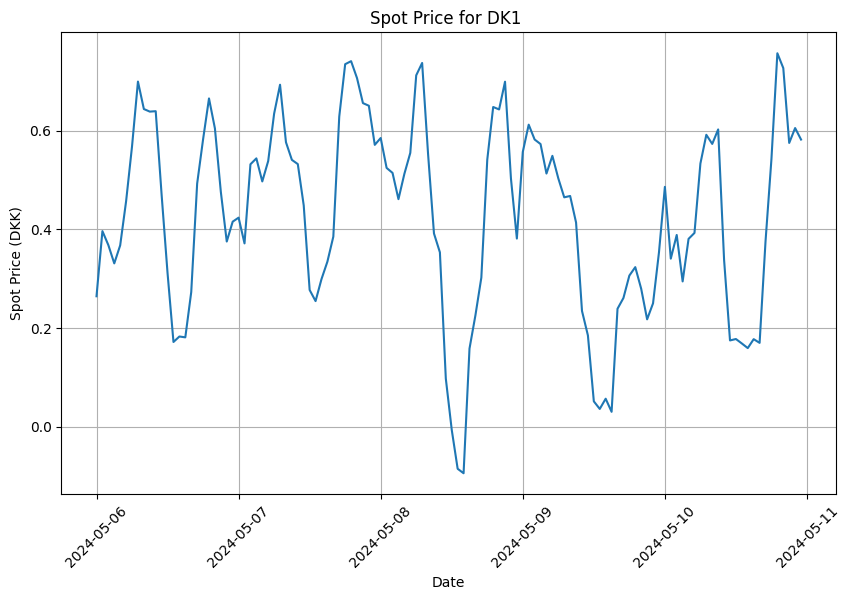

In [12]:
# Importing matplotlib for plotting
import matplotlib.pyplot as plt

# Group the data by date and calculate the average temperature for each day
daily_data = predictions_df.groupby('time')['prediction'].mean()
 
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(daily_data.index, daily_data.values)
plt.xlabel('Date')
plt.ylabel('Spot Price (DKK)')
plt.title('Spot Price for DK1 ')
plt.xticks(rotation=45)
plt.grid(True)
 
# Show the plot
plt.show()

In [13]:
# Importing Altair for interactive visualization
import altair as alt

# Create Altair chart with line and dots
chart = alt.Chart(predictions_df).mark_line(point=True).encode(
    x='time:T', 
    y='prediction:Q', 
    # Adding tooltips for interactive information display
    tooltip=[alt.Tooltip('time:T', title='Date', format='%Y-%m-%d'), 
             alt.Tooltip('time:T', title='Time', format='%H:%M'), 
             alt.Tooltip('prediction:Q', title='Spot Price (DKK)', format='.2f')
            ]
)
 
# Display the chart
chart.interactive()

alt.Chart(...)

---
## <span style="color:#2656a3;">⏭️ **Next:** Creating our app.py for a streamlit application ([link](https://github.com/Camillahannesbo/MLOPs-Assignment-/blob/main/app.py)) </span>
